In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST, SVHN
from torchvision import transforms
import pytorch_lightning as pl

from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from torchmetrics import Accuracy

sns.set()

In [2]:
# Source: https://stackoverflow.com/questions/11882393/matplotlib-disregard-outliers-when-plotting
def is_not_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score <= thresh

def VisualizeFeatures(layer, legend = "weights", remove_outlier = True, df = None):
    w = layer.weight.clone().detach().cpu().numpy()
    w = w.flatten()
    
    MAX_LEN = 16384
    
    if len(w) > MAX_LEN:
        w = np.random.choice(w, MAX_LEN)
        
    if remove_outlier:
        w = w[is_not_outlier(w)]
        
    _df = pd.DataFrame({legend: w})
    if df is not None:
        df = pd.concat([df, _df], axis = 1)
    else:
        df = _df
        
    plt.figure(figsize=(10,5))
    sns.histplot(df, fill = True, kde = True).set(title='Features of - %s' % (repr(layer)))
    plt.show()
    
    return df

In [3]:
class LitClassifier(pl.LightningModule):
    
    def __init__(self, input_dim, output_dim, hidden_dim, nonlin = nn.ReLU()):
        
        super().__init__()
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim // 2),
            nonlin,
            nn.Linear(hidden_dim // 2, hidden_dim),
            nonlin,
            nn.Linear(hidden_dim, output_dim)
        )
        
        self.accuracy = Accuracy()
        
        # self.net.

    def forward(self, x):
        embedding = self.net(x)
        return embedding

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        
        x = x.view(x.size(0), -1)
        logits = self(x)
        
        # loss = F.cross_entropy(logits, y)
        loss = F.mse_loss(logits, F.one_hot(y).float())
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        x = x.view(x.size(0), -1)
        logits = self(x)
        
        loss = F.mse_loss(logits, F.one_hot(y).float())
        self.accuracy(torch.argmax(logits, dim = 1), y)
        
        self.log("val_acc", self.accuracy, prog_bar=True)
        self.log("val_loss", loss)
        
        return loss

In [4]:
class LitAutoEncoder(pl.LightningModule):
    
    def __init__(self, input_dim, output_dim, hidden_dim, nonlin = nn.ReLU(), noiseAmount = 0.3):
        
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nonlin,
            nn.Dropout(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.classifier = nn.Linear(hidden_dim, output_dim)
        
        self.noiseAmount = noiseAmount
        self.classify = False
        
        self.accuracy = Accuracy()

    def forward(self, x):
        embedding = self.net(x)
        return embedding

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # optimizer = torch.optim.SGD(self.parameters())
        return optimizer
    
    def go_classify(self):
        self.net[-1] = nn.Linear(self.hidden_dim, self.output_dim)
        self.classify = True
    
    def training_step(self, train_batch, batch_idx):
        if self.classify:
            return self.train_classify(train_batch, batch_idx)
        else:
            return self.train_AE(train_batch, batch_idx)
        
    def train_AE(self, train_batch, batch_idx):
        x, y = train_batch
        x = x.view(x.size(0), -1)
        xx = x.clone()
        
        # TODO: Apply noise here
        mask = (torch.rand_like(x) < self.noiseAmount)
        x[mask] = 0.0
        
        x_hat = self.net(x)
        
        # TODO: Apply mask here
#         loss = F.mse_loss(x_hat, x)
        loss = F.mse_loss(x_hat * mask, xx * mask, reduction = 'sum') / (mask.long().sum())
        
        self.log('train_loss', loss)
        return loss
    
    def train_classify(self, train_batch, batch_idx):
        
        x, y = train_batch
        x = x.view(x.size(0), -1)
        logits = self.net(x)
        
        loss = F.mse_loss(logits, F.one_hot(y).float())
        
        self.log('train_loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        if self.classify:
            return self.validation_classify(val_batch, batch_idx)
        else:
            return self.validation_AE(val_batch, batch_idx)
        
    def validation_AE(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        x_hat = self.net(x)
        loss = F.mse_loss(x_hat, x)
        self.log('val_loss', loss)
        
    def validation_classify(self, val_batch, batch_idx):
        x, y = val_batch
        x = x.view(x.size(0), -1)
        logits = self.net(x)
        loss = F.mse_loss(logits, F.one_hot(y).float())
        
        self.accuracy(torch.argmax(logits, dim = 1), y)
        
        self.log("val_acc", self.accuracy, prog_bar=True)
        self.log("val_loss", loss)
        
        return loss

Using downloaded and verified file: data/train_32x32.mat
Using downloaded and verified file: data/test_32x32.mat


Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..


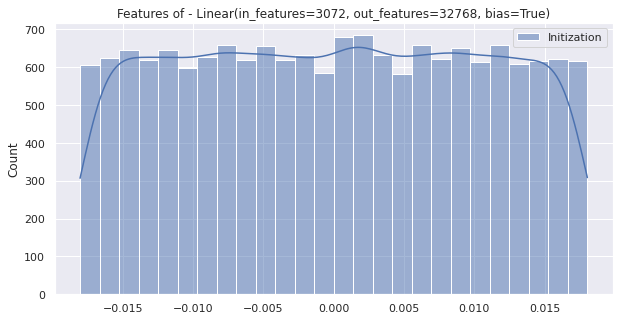

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Sequential | 201 M 
1 | classifier | Linear     | 327 K 
2 | accuracy   | Accuracy   | 0     
------------------------------------------
201 M     Trainable params
0         Non-trainable params
201 M     Total params
403.380   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [5]:
# data
use_data = 'svhn'
if use_data == 'mnist':
    dataset = MNIST('data/', train = True, download = True,
                     transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])
                   )
    testset = MNIST('data/', train = False, download = True,
                     transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize((0.1307,), (0.3081,))
                        ])
                   )
    mnist_train, mnist_val = random_split(dataset, [55000, 5000])
else:
    dataset = SVHN('data/', split = 'train', download = True,
                 transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
               )
    testset = SVHN('data/', split = 'test', download = True,
                 transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                    ])
               )
    # print(len(dataset))
    mnist_train, mnist_val = random_split(dataset, [70000, 3257])

train_loader = DataLoader(mnist_train, batch_size=512, num_workers = 16)
val_loader = DataLoader(mnist_val, batch_size=512, num_workers = 16)

# model
if use_data == 'mnist':
    input_dim = 28 * 28
else:
    input_dim = 32 * 32 * 3

model = LitAutoEncoder(input_dim, 10, 32768, noiseAmount = 0.3)
# model = LitClassifier(input_dim, 10, 16384)
# model = LitClassifier(input_dim, 10, 32768)

# training
trainer = pl.Trainer(
    gpus=1,
    num_nodes=1,
    enable_progress_bar=True,
    precision=16,
    
    limit_train_batches=1.0,
    limit_val_batches = 1.0,
    
    enable_checkpointing=False,
    
    max_epochs = 100
)

vis = VisualizeFeatures(model.net[0], "Initization")

trainer.fit(model, train_loader, val_loader)

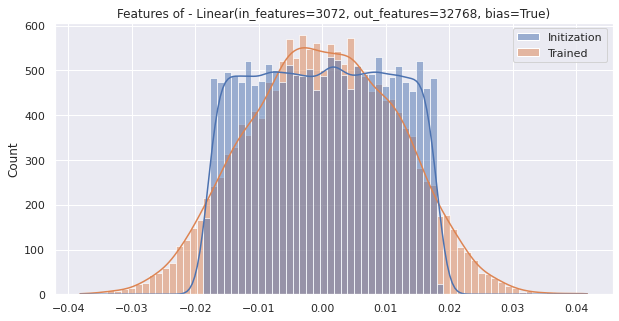

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type       | Params
------------------------------------------
0 | net        | Sequential | 101 M 
1 | classifier | Linear     | 327 K 
2 | accuracy   | Accuracy   | 0     
------------------------------------------
101 M     Trainable params
0         Non-trainable params
101 M     Total params
202.703   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

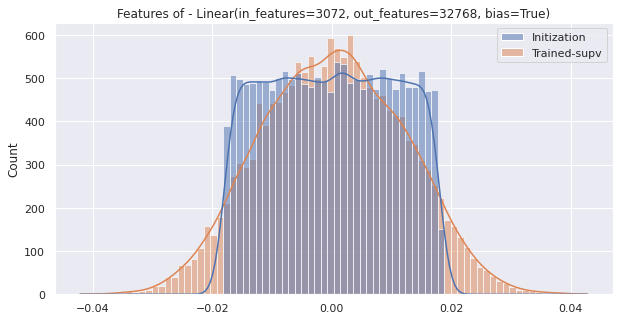

,Initization,Trained-supv
0,-0.012050,0.010013
1,0.016888,0.024099
2,0.010059,-0.009477
3,0.014676,-0.009257
4,0.016492,0.018190
...,...,...
16379,-0.005813,-0.002503
16380,-0.016245,-0.012566
16381,-0.004029,NaN
16382,0.008421,NaN


In [6]:
VisualizeFeatures(model.net[0], "Trained", df = vis)

model.go_classify()

trainer = pl.Trainer(
    gpus=1,
    num_nodes=1,
    enable_progress_bar=True,
    precision=16,
    
    limit_train_batches=1.0,
    limit_val_batches = 1.0,
    
    enable_checkpointing=False,
    
    max_epochs = 15
)
trainer.fit(model, train_loader, val_loader)
model.eval()

VisualizeFeatures(model.net[0], "Trained-supv", df = vis)

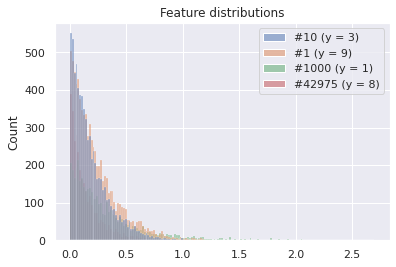

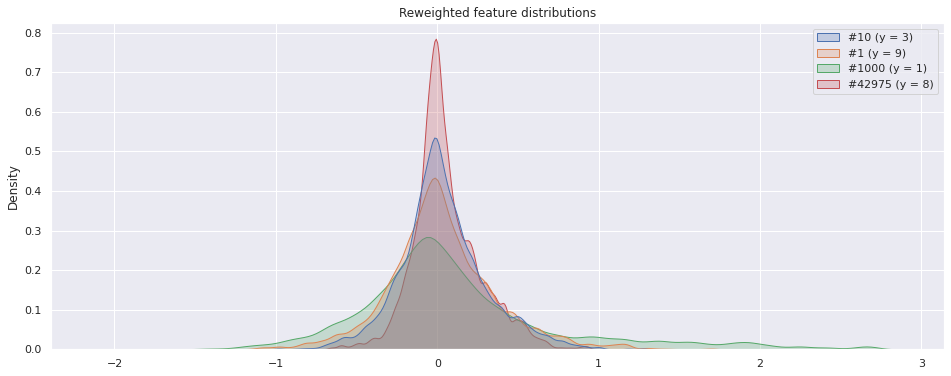

In [7]:
import importlib
import ReweightedFeatures

importlib.reload(ReweightedFeatures)

def Visualize(dataset, model, idxs, dropout = 0.0, fidx = 0):

    feat = pd.DataFrame()
    featraw = pd.DataFrame()
    featr = pd.DataFrame()
    
    for idx in idxs:
        
        x, y = dataset[idx]
        
        # x = torch.randn_like(x)
        # TODO: Apply noise here
        mask = (torch.rand_like(x) < dropout)
        x[mask] = 0.0
        
        # plt.imshow(x.squeeze(0))
        # plt.title("Datapoint visualization of #%d (y = %d); Prediction:\n%s" % (idx, y, str(model(x.flatten()).detach().cpu().numpy())))
        # plt.show()

        # Get final layer features
        x_input = x.flatten()

        for l in model.net[:-1]:
            x_input = l(x_input)

        features = x_input.detach()
        weights = model.net[-1].weight
        
        # Reweight
        y_weight = weights[y].detach()
        reweighted = ReweightedFeatures.ReweightFeatures(features.unsqueeze(0), y_weight, relu = True)
        
        # reweighted = features * torch.sign(y_weight)
        # reweighted = features * y_weight
        # reweighted = reweighted[reweighted != 0].detach().unsqueeze(0)
        
        entry = '#%d (y = %d)' % (idx, y)
        feat = pd.concat([feat, pd.DataFrame({entry: features[features != 0].cpu().numpy()})])
        featr = pd.concat([featr, pd.DataFrame({
            entry: reweighted[0].cpu().numpy()
        })])
        
        # featraw[entry] = features.cpu().numpy()        
        # featraw['x'] = np.array([i for i in range(features.shape[0])])
        
    sns.histplot(feat, kde = False)
    plt.title("Feature distributions")
    plt.show()

    # sns.lineplot(featraw)
    # plt.title("Features")
    # plt.show()

    plt.figure(figsize = (16, 6))
    # sns.histplot(featr, kde = True, kde_kws = {"bw_adjust": 0.5})
    sns.kdeplot(data = featr, fill = True, bw_adjust = 0.8)
    plt.title("Reweighted feature distributions")
    # plt.savefig("Figs/%03d.png" % fidx)
    # TODO: Fix xlim / ylim / legend
    plt.show()

# for i in range(27, 50):
    # print(i)
    # Visualize(dataset, model, [10, 1, 1000, 42975], dropout = i * 0.02, fidx = i)
Visualize(dataset, model, [10, 1, 1000, 42975])
# Visualize(dataset, model, [42975, 1000])

<AxesSubplot:ylabel='Count'>

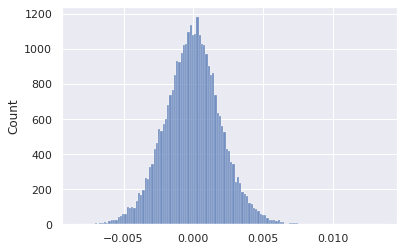

In [8]:
sns.histplot(model.net[-1].weight[0].detach())

In [10]:
from tqdm.auto import tqdm

importlib.reload(ReweightedFeatures)

features = []
features_dist = []
features_reweighted = []
features_act = []

for data in tqdm(dataset):
    
    x, y = data

    # Get final layer features
    x_input = x.flatten()

    for l in model.net[:-1]:
        x_input = l(x_input)

    f = x_input.detach()
    f_dist, _ = torch.sort(x_input)
    w = model.net[-1].weight

    # Reweight
    y_weight = w[y].detach()
    reweighted = ReweightedFeatures.ReweightFeatures(f.unsqueeze(0), y_weight, relu = True)[0].cpu().numpy()
    act, _ = torch.sort(f * y_weight)
    
    assert not torch.Tensor(reweighted).isnan().any()
    
    features.append(f.cpu().numpy())
    features_dist.append(f_dist.detach().cpu().numpy())
    features_act.append(act.detach().cpu().numpy())
    features_reweighted.append(reweighted)

features = np.stack(features, axis = 0)
features_dist = np.stack(features_dist, axis = 0)
features_act = np.stack(features_act, axis = 0)
features_reweighted = np.stack(features_reweighted, axis = 0)

  0%|          | 0/73257 [00:00<?, ?it/s]

In [11]:
allf = features
allfd = features_dist
allfa = features_act
allfdr = features_reweighted

In [14]:
y = dataset.labels

In [15]:
import umap
embedder = umap.UMAP(verbose = True)

In [18]:
emb = embedder.fit_transform(allfd)

UMAP( verbose=True)
Fri Apr 22 12:22:06 2022 Construct fuzzy simplicial set
Fri Apr 22 12:22:08 2022 Finding Nearest Neighbors
Fri Apr 22 12:22:10 2022 Building RP forest with 19 trees
Fri Apr 22 12:22:36 2022 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	Stopping threshold met -- exiting after 2 iterations
Fri Apr 22 12:22:56 2022 Finished Nearest Neighbor Search
Fri Apr 22 12:22:58 2022 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Fri Apr 22 12:23:26 2022 Finished embedding


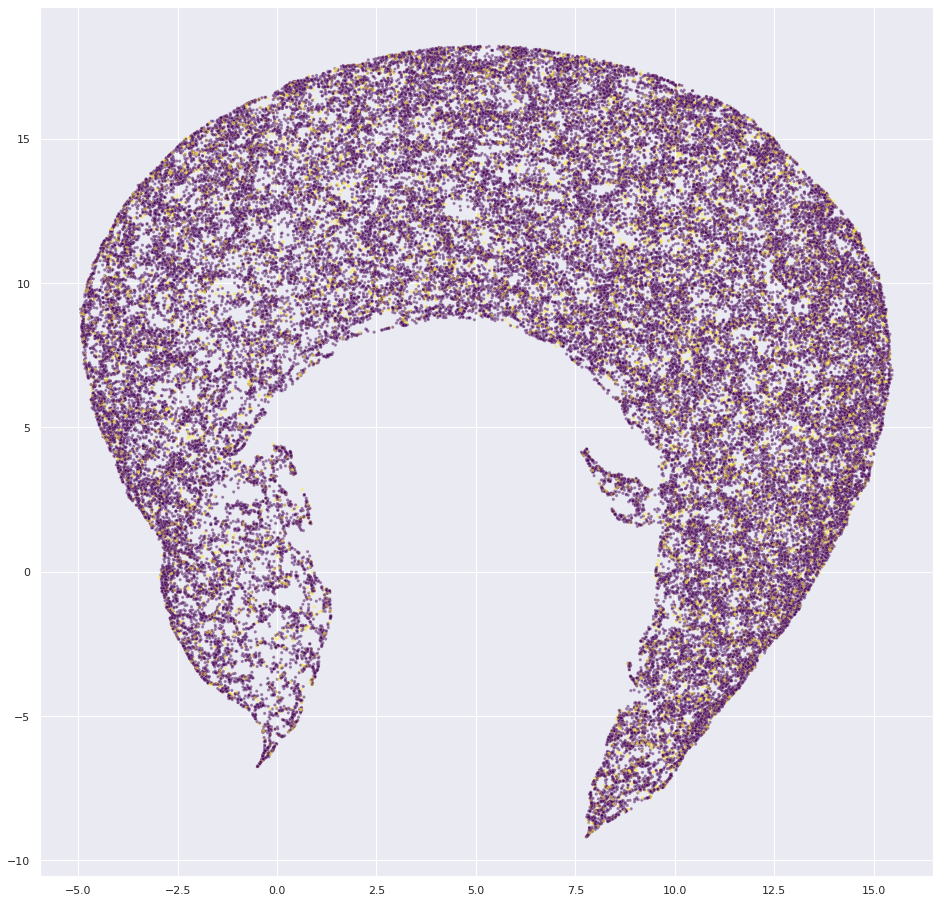

In [19]:
plt.figure(figsize = (16,16))
# sns.scatterplot(x = emb[:, 0], y = emb[:, 1], c = y, cmap = 'tab10')
plt.scatter(x = emb[:, 0], y = emb[:, 1], c = (y==3), alpha = 0.5, cmap = 'viridis', s = 10, linewidths = 0.2, edgecolors = 'white')

###### 